In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import nibabel as nib
import pygalmesh
from mpi4py import MPI
import fenics as fe
import fenics_adjoint as fa
import torch
import torch.nn.functional as F
import torch_fenics
import tqdm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('..')
import project

--------------------------------------------------------------------------

  Local host:   dv004
  Local device: mlx5_0
--------------------------------------------------------------------------


In [3]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')

In [4]:
mesh_radius = 20

examples = []
for case in emory4dct.cases:
    for fixed_phase in emory4dct.phases:
        moving_phase = (fixed_phase + 10) % 100
        
        anat_file = case.nifti_file(fixed_phase)
        disp_file = case.disp_file(moving_phase, fixed_phase)
        mask_file = case.mask_file(fixed_phase, roi='lung_combined_mask')
        mesh_file = case.mesh_file(fixed_phase, radius=mesh_radius)
        
        example = (anat_file, disp_file, mask_file, mesh_file)
        examples.append(example)
        
len(examples)

100

In [5]:
class Dataset(torch.utils.data.Dataset):
     
    def __init__(self, examples, dtype=torch.float32, device='cuda'):
        super().__init__()

        self.examples = examples
        self.dtype = dtype
        self.device = device

        self.cache = [None] * len(examples)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        if self.cache[idx] is None:
            self.cache[idx] = self.load_example(idx)
        return self.cache[idx]
    
    def load_example(self, idx):
        anat_file, disp_file, mask_file, mesh_file = self.examples[idx]    
        example_name = anat_file.stem
        
        # load images from NIFTI files
        anat = load_nii_file(anat_file)
        disp = load_nii_file(disp_file)
        mask = load_nii_file(mask_file)
        
        # load mesh from xdmf file
        mesh = load_mesh_file(mesh_file)

        # get image spatial resolution
        resolution = anat.header.get_zooms()

        # convert arrays to tensors with shape (c,x,y,z)
        anat = torch.as_tensor(anat.get_fdata(), dtype=self.dtype, device=self.device).unsqueeze(0)
        disp = torch.as_tensor(disp.get_fdata(), dtype=self.dtype, device=self.device).permute(3,0,1,2)
        mask = torch.as_tensor(mask.get_fdata(), dtype=self.dtype, device=self.device).unsqueeze(0)

        return anat, disp, mask, mesh, resolution, example_name
    
def load_nii_file(nii_file):
    print(f'Loading {nii_file}... ', end='')
    nifti = nib.load(nii_file)
    print(nifti.header.get_data_shape())
    return nifti

def load_mesh_file(mesh_file):
    print(f'Loading {mesh_file}... ', end='')
    mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, str(mesh_file)) as f:
        f.read(mesh)
    print(mesh.num_vertices())
    return mesh

def collate_fn(batch):
    # we need a custom collate_fn bc mesh is not a tensor
    anat = torch.stack([ex[0] for ex in batch])
    mask = torch.stack([ex[1] for ex in batch])
    disp = torch.stack([ex[2] for ex in batch])
    resolution = [ex[3] for ex in batch]
    mesh = [ex[4] for ex in batch]
    name = [ex[5] for ex in batch]
    return anat, mask, disp, resolution, mesh, name

dataset = Dataset(examples, dtype=torch.float32, device='cuda')
example = dataset[0]

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T10_T00.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T00_20.xdmf... 346


In [6]:
def my_tensor_repr(t):
    shape = tuple(t.shape)
    is_nan = t.float().isnan()
    not_nan = ~is_nan
    num_nan = is_nan.sum()
    mean = t[not_nan].mean()
    std = t[not_nan].std() if not_nan.sum() > 1 else np.nan # hide the torch warning
    return f'Tensor(shape={shape}, μ={mean:.4f}, σ={std:.4f}, #nan={num_nan}, dtype={t.dtype}, device={t.device})'

torch.Tensor.__repr__ = my_tensor_repr

example

(Tensor(shape=(1, 256, 256, 94), μ=-487.4489, σ=477.8683, #nan=0, dtype=torch.float32, device=cuda:0),
 Tensor(shape=(3, 256, 256, 94), μ=0.0061, σ=0.2449, #nan=0, dtype=torch.float32, device=cuda:0),
 Tensor(shape=(1, 256, 256, 94), μ=0.1570, σ=0.3638, #nan=0, dtype=torch.float32, device=cuda:0),
 (0.97, 0.97, 2.5),
 'case1_T00.nii')

In [7]:
class ConvUnit(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.norm = torch.nn.BatchNorm3d(in_channels)
        self.conv = torch.nn.Conv3d(in_channels, out_channels, kernel_size, padding='same', padding_mode='replicate')
        self.relu = torch.nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        x = self.norm(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class ConvBlock(torch.nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size, num_conv_layers, hidden_channels=None):
        super().__init__()
        
        if not hidden_channels:
            hidden_channels = out_channels
        elif num_conv_layers < 2:
            print('Warning: hidden_channels argument only used if num_conv_layers >= 2')

        for i in range(num_conv_layers):
            layer = ConvUnit(
                in_channels=(hidden_channels if i > 0 else in_channels),
                out_channels=(hidden_channels if i < num_conv_layers - 1 else out_channels),
                kernel_size=kernel_size
            )
            self.add_module(f'conv_unit{i}', layer)
            

class Upsample(torch.nn.Module):
    
    def __init__(self, mode):
        super().__init__()
        self.mode = mode
        
    def __repr__(self):
        return f'{type(self).__name__}(mode={self.mode})'
        
    def forward(self, x, size):
        return F.interpolate(x, size=size, mode=self.mode)


class EncoderBlock(torch.nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size,
        num_conv_layers,
        hidden_channels=None,
        apply_pooling=True,
        pool_kernel_size=2,
        pool_type='max'
    ):
        super().__init__()
        assert pool_type in {'max', 'avg'}

        if apply_pooling:
            if pool_type == 'max':
                self.pooling = torch.nn.MaxPool3d(kernel_size=pool_kernel_size)
            elif pool_type == 'avg':
                self.pooling = torch.nn.AvgPool3d(kernel_size=pool_kernel_size)
        else:
            self.pooling = None
            
        self.conv_block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            num_conv_layers=num_conv_layers,
            hidden_channels=hidden_channels
        )
        
    def forward(self, x):
        if self.pooling:
            x = self.pooling(x)
        x = self.conv_block(x)
        return x


class DecoderBlock(torch.nn.Module):
    
    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size,
        num_conv_layers,
        hidden_channels=None,
        upsample_mode='nearest'
    ):
        super().__init__()

        self.upsample = Upsample(mode=upsample_mode)

        self.conv_block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            num_conv_layers=num_conv_layers,
            hidden_channels=hidden_channels,
        )

    def forward(self, x, encoder_feats):
        x = self.upsample(x, size=encoder_feats.shape[2:])
        x = torch.cat([x, encoder_feats], dim=1)
        x = self.conv_block(x)
        return x


In [8]:
class UNet3D(torch.nn.Module):
    
    def __init__(
        self,
        in_channels,
        out_channels,
        num_levels,
        num_conv_layers,
        conv_channels,
        conv_kernel_size,
        pool_kernel_size=2,
        pool_type='max',
        upsample_mode='trilinear',
    ):
        super().__init__()
        assert num_levels > 0
        
        curr_channels = in_channels
        next_channels = conv_channels
        
        self.encoder = torch.nn.Sequential()
        for i in range(num_levels):
        
            encoder_block = EncoderBlock(
                in_channels=curr_channels,
                out_channels=next_channels,
                conv_kernel_size=conv_kernel_size,
                num_conv_layers=num_conv_layers,
                apply_pooling=(i > 0),
                pool_kernel_size=pool_kernel_size,
                pool_type=pool_type
            )
            self.encoder.add_module(f'level{i}', encoder_block)

            curr_channels = next_channels
            next_channels = curr_channels * 2
        
        next_channels = curr_channels // 2
        
        self.decoder = torch.nn.Sequential()
        for i in reversed(range(num_levels - 1)):

            decoder_block = DecoderBlock(
                in_channels=curr_channels + next_channels,
                out_channels=next_channels,
                conv_kernel_size=conv_kernel_size,
                num_conv_layers=num_conv_layers,
                upsample_mode=upsample_mode
            )
            self.decoder.add_module(f'level{i}', decoder_block)
            
            curr_channels = next_channels
            next_channels = curr_channels // 2
        
        self.final_conv = torch.nn.Conv3d(curr_channels, out_channels, kernel_size=1)

    def forward(self, x):
        
        # encoder part
        encoder_feats = []
        for i, encoder in enumerate(self.encoder):
            x = encoder(x)
            encoder_feats.append(x)
        
        # reverse encoder features to align with decoder
        encoder_feats = encoder_feats[::-1]
    
        # decoder part
        for i, decoder in enumerate(self.decoder):
            x = decoder(x, encoder_feats[i+1])

        return self.final_conv(x)


model = UNet3D(in_channels=1, out_channels=1, num_levels=3, num_conv_layers=2, conv_channels=4, conv_kernel_size=3)
model.cuda()

UNet3D(
  (encoder): Sequential(
    (level0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv_unit0): ConvUnit(
          (norm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (conv_unit1): ConvUnit(
          (norm): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (level1): EncoderBlock(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_block): ConvBlock(
        (conv_unit0): ConvUnit(
          (norm): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [9]:
class LinearElasticPDE(torch_fenics.FEniCSModule):
    
    def __init__(self, mesh):
        super().__init__()
        self.mesh = mesh
        self.S = fe.FunctionSpace(mesh, 'P', 1)
        self.V = fe.VectorFunctionSpace(mesh, 'P', 1)
        
    def __repr__(self):
        return f'{type(self).__name__}({self.mesh})'
        
    def input_templates(self):
        scalar_f = fa.Function(self.S)
        vector_f = fa.Function(self.V)
        return vector_f, scalar_f, scalar_f
    
    def solve(self, u_true, mu, rho):

        # define physical parameters
        g  = 9.8e-3 # gravitational acc (mm/s^2)
        nu = 0.4    # Poisson's ratio (unitless)

        # Lame's first parameter (Pa)
        lam = 2*mu*nu/(1 - 2*nu)

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.V, u_true, 'on_boundary')

        # body force and traction
        #b = fe.as_vector([0, rho*g, 0])
        b = fa.Constant([0, 0, 0])
        t = fa.Constant([0, 0, 0])

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam*fe.div(u)*I + 2*mu*epsilon(u)

        # weak formulation
        u = fe.TrialFunction(self.V)
        v = fe.TestFunction(self.V)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v)*fe.dx + fe.dot(t, v)*fe.dx

        u_pred = fa.Function(self.V)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred


In [10]:
def as_xarray(a, dims=None, coords=None, name=None):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if dims is None:
        dims = [f'dim{i}' for i in range(a.ndim)]
    if coords is None:
        coords = {d: np.arange(a.shape[i]) for i, d in enumerate(dims)}
    return xr.DataArray(a, dims=dims, coords=coords, name=name)

#project.visual.view(as_xarray(output_image[0], dims=['component', 'x', 'y', 'z']), cmap='seismic')

case1_T00.nii
Tensor(shape=(1, 256, 256, 94), μ=-487.4489, σ=477.8683, #nan=0, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


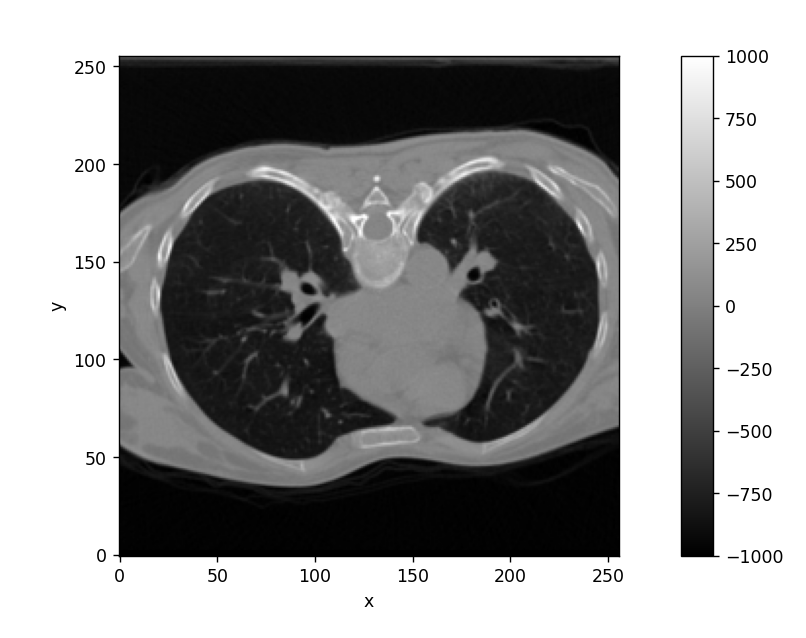

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [34]:
anat_image, u_true_image, mask, mesh, resolution, example_name = example
print(example_name)
print(anat_image)

project.visual.view(as_xarray(anat_image, dims=['channel', 'x', 'y', 'z'], name='CT')).update_index(channel=0, z=45)

Tensor(shape=(1, 256, 256, 94), μ=940.5217, σ=139.7628, #nan=0, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


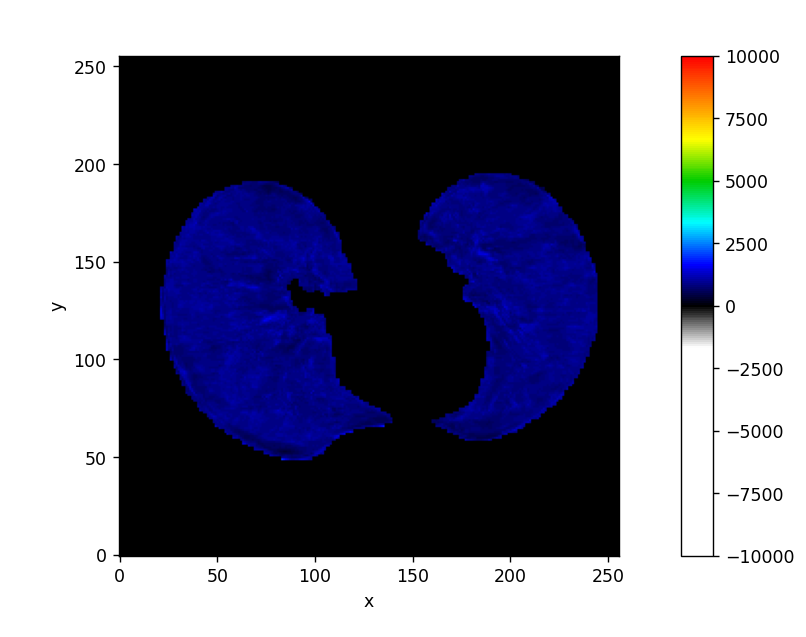

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [35]:
mu_pred_image = model.forward(anat_image.unsqueeze(0))[0]
mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000
print(mu_pred_image)

project.visual.view(as_xarray(mu_pred_image * mask, dims=['channel', 'x', 'y', 'z'], name='mu'), vmax=1e4).update_index(channel=0, z=45)

Tensor(shape=(1, 256, 256, 94), μ=512.5510, σ=477.8683, #nan=0, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


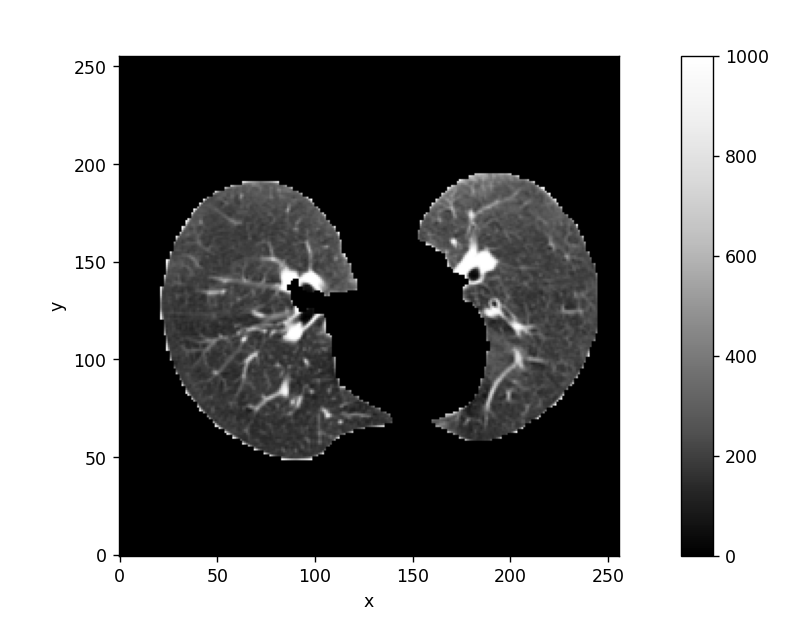

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [36]:
rho_image = (1 + anat_image/1000) * 1000
print(rho_image)

project.visual.view(as_xarray(rho_image * mask, dims=['channel', 'x', 'y', 'z']), cmap='Greys_r', vmin=0, vmax=1000).update_index(channel=0, z=45)

<IPython.core.display.Javascript object>


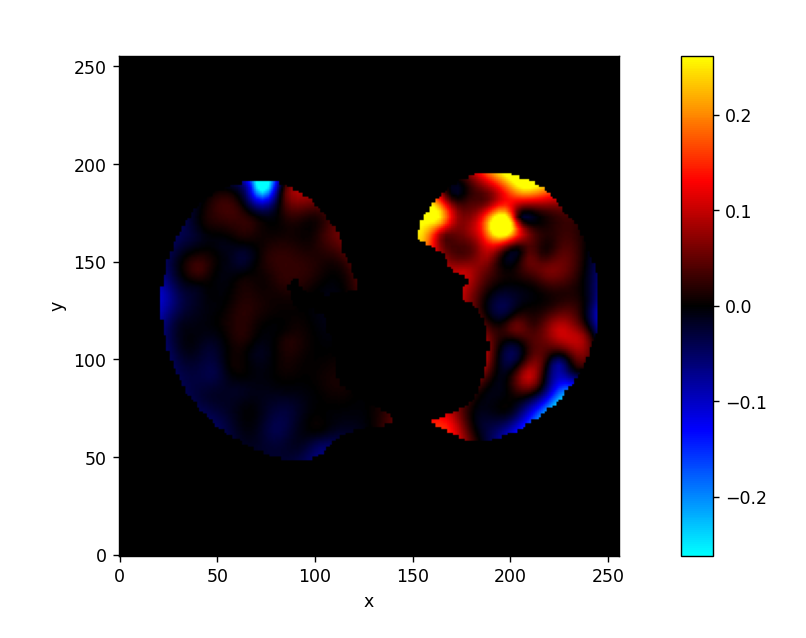

interactive(children=(SelectionSlider(description='channel', options=((0, 0), (1, 1), (2, 2)), value=0), Selec…

In [37]:
project.visual.view(as_xarray(u_true_image * mask, dims=['channel', 'x', 'y', 'z'])).update_index(channel=2, z=45)

In [38]:
pde = LinearElasticPDE(mesh)

In [54]:
%autoreload
u_true_dofs = project.interpolate.image_to_dofs(u_true_image, resolution, pde.V, radius=20, sigma=mesh_radius/2).cpu()
u_true_dofs

Tensor(shape=(346, 3), μ=0.0042, σ=0.1309, #nan=0, dtype=torch.float64, device=cpu)

In [55]:
mu_pred_image = mu_pred_image.detach()
mu_pred_image.requires_grad = True

mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image, resolution, pde.S, radius=20, sigma=mesh_radius/2).cpu()
mu_pred_dofs

Tensor(shape=(346,), μ=927.9944, σ=43.8645, #nan=0, dtype=torch.float64, device=cpu)

In [56]:
rho_dofs = project.interpolate.image_to_dofs(rho_image, resolution, pde.S, radius=20, sigma=mesh_radius/2).cpu()
rho_dofs

Tensor(shape=(346,), μ=599.6329, σ=179.5162, #nan=0, dtype=torch.float64, device=cpu)

In [57]:
u_pred_dofs = pde.forward(
    u_true_dofs.unsqueeze(0),
    mu_pred_dofs.unsqueeze(0),
    rho_dofs.unsqueeze(0),
)[0]

u_pred_dofs

Tensor(shape=(346, 3), μ=0.0017, σ=0.1362, #nan=0, dtype=torch.float64, device=cpu)

In [58]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_dofs, pde.V, u_true_image.shape[-3:], resolution)
u_pred_image

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


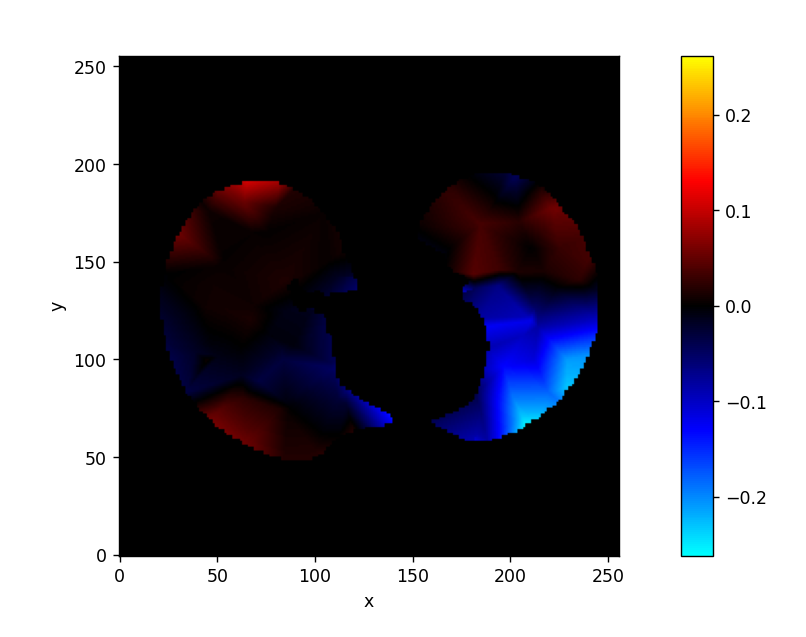

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [44]:
project.visual.view(as_xarray(u_pred_image * mask.permute(1,2,3,0).detach().cpu().numpy(), dims=['x', 'y', 'z', 'c'])).update_index(c=0, z=45)

In [59]:
def compute_norm(u):
    u_norm2 = (u**2).sum(dim=-1)
    return torch.mean(u_norm2)

def compute_loss(u_pred, u_true, eps=1e-8):
    u_diff = (u_pred - u_true)
    u_diff_norm2 = (u_diff**2).sum(dim=-1)
    u_true_norm2 = (u_true**2).sum(dim=-1) + eps
    return torch.mean(u_diff_norm2 / u_true_norm2)

L = compute_loss(u_pred_dofs, u_true_dofs)
L.backward()

In [60]:
mu_pred_image.grad

Tensor(shape=(1, 256, 256, 94), μ=-0.0000, σ=0.0000, #nan=0, dtype=torch.float32, device=cuda:0)

<IPython.core.display.Javascript object>


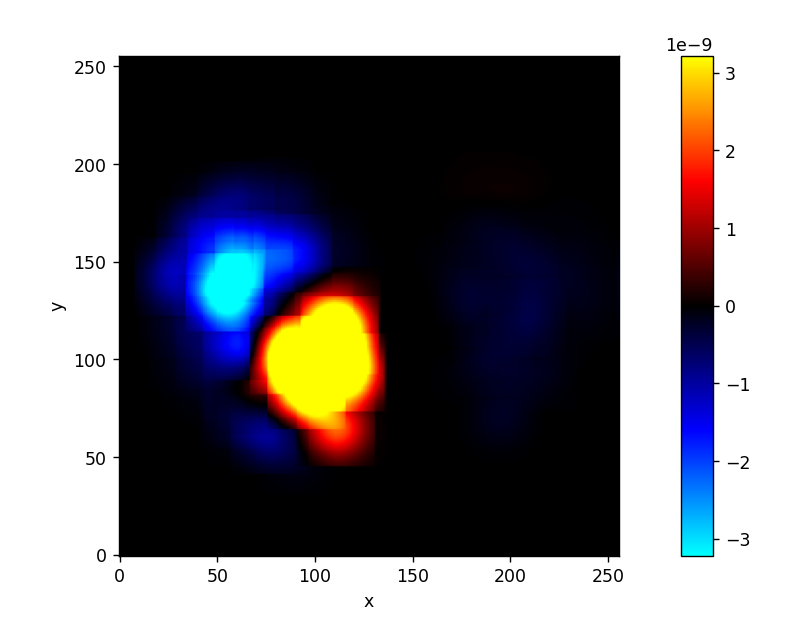

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [61]:
project.visual.view(as_xarray(mu_pred_image.grad, dims=['channel', 'x', 'y', 'z'])).update_index(channel=0, z=45)

In [74]:
class Trainer(object):
    
    def __init__(self, model, dataset, batch_size, learning_rate):
        self._model = model
        self.train_loader = torch.utils.data.DataLoader(
            dataset, batch_size, shuffle=True, collate_fn=collate_fn
        )
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.epoch = 0
        
        index_cols = ['epoch', 'batch', 'example', 'phase']
        self.metrics = pd.DataFrame(columns=index_cols)
        self.metrics.set_index(index_cols, inplace=True)
        
    @property
    def model(self):
        return self._model
    
    @property
    def dataset(self):
        return self.train_loader.dataset
        
    @property
    def batch_size(self):
        return self.train_loader.batch_sampler.batch_size
    
    @property
    def learning_rate(self):
        return self.optimizer.param_groups[0]['lr']
    
    def __repr__(self):
        if self.epoch > 0:
            loss = self.metrics.loc[self.epoch, 'loss'].mean()
        else:
            loss = None
        return f'{type(self).__name__}(epoch={self.epoch}, loss={loss})'
        
    def train(self, num_epochs):
        
        start_epoch = self.epoch
        stop_epoch = self.epoch + num_epochs

        print('Training...')
        for i in range(start_epoch, stop_epoch):
            print(f'Epoch {i+1}/{stop_epoch}')
            
            for j, batch in enumerate(self.train_loader):
                anat_image, u_true_image, mask, mesh, resolution, example_name = batch

                # predict elasticity from anatomical image
                mu_pred_image = self.model.forward(anat_image)
                mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000
                rho_image = (1 + anat_image/1000) * 1000

                # physical FEM simulation
                loss = 0
                for k in range(self.batch_size):          
                    pde = LinearElasticPDE(mesh[k])

                    # convert tensors to FEM basis coefficients
                    u_true_dofs = project.interpolate.image_to_dofs(u_true_image[k], resolution[k], pde.V, radius=20, sigma=mesh_radius/2).cpu()
                    mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image[k], resolution[k], pde.S, radius=20, sigma=mesh_radius/2).cpu()
                    rho_dofs = project.interpolate.image_to_dofs(rho_image[k], resolution[k], pde.S, radius=20, sigma=mesh_radius/2).cpu()
    
                    # solve FEM for simulated displacement coefficients
                    u_pred_dofs = pde.forward(
                        u_true_dofs.unsqueeze(0),
                        mu_pred_dofs.unsqueeze(0),
                        rho_dofs.unsqueeze(0),
                    )[0]
    
                    # compare to true displacement coefficients
                    loss_k = compute_loss(u_pred_dofs, u_true_dofs)
                    loss += loss_k
                
                    # compute additional metrics
                    key = (i+1, j+1, example_name[k], 'train')
                    self.metrics.loc[key, 'loss'] = loss_k.item()
                    self.metrics.loc[key, 'mu_pred_norm'] = compute_norm(mu_pred_dofs).item()
                    self.metrics.loc[key, 'u_pred_norm'] = compute_norm(u_pred_dofs).item()
                    self.metrics.loc[key, 'u_true_norm'] = compute_norm(u_true_dofs).item()
            
                loss /= self.batch_size
                print(f'{example_name} loss = {loss:.4f}')
                
                loss.backward()
                self.optimizer.step()
            
            self.epoch += 1
    
    def test(self, example):
        anat_image, u_true_image, mask, mesh, resolution, example_name = example
        
        # predict elasticity from anatomical image
        mu_pred_image = self.model.forward(anat_image.unsqueeze(0))[0]
        mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000
        rho_image = (1 + anat_image/1000) * 1000
        
        # physical FEM simulation
        pde = LinearElasticPDE(mesh)
        
        # convert tensors to FEM basis coefficients
        u_true_dofs = project.interpolate.image_to_dofs(u_true_image, resolution, pde.V, radius=20, sigma=mesh_radius/2).cpu()
        mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image, resolution, pde.S, radius=20, sigma=mesh_radius/2).cpu()
        rho_dofs = project.interpolate.image_to_dofs(rho_image, resolution, pde.S, radius=20, sigma=mesh_radius/2).cpu()

        # solve FEM for simulated displacement coefficients
        u_pred_dofs = pde.forward(
            u_true_dofs.unsqueeze(0),
            mu_pred_dofs.unsqueeze(0),
            rho_dofs.unsqueeze(0),
        )[0]

        # compare to true displacement coefficients
        loss = compute_loss(u_pred_dofs, u_true_dofs)
        
        # convert simulated displacement field to image domain      
        u_pred_image = project.interpolate.dofs_to_image(u_pred_dofs, pde.V, u_true_image.shape[-3:], resolution)
        u_pred_image = torch.as_tensor(u_pred_image).permute(3,0,1,2)
        
        return mu_pred_image, u_pred_image

trainer = Trainer(model, dataset, batch_size=4, learning_rate=1e-5)
trainer

Trainer(epoch=0, loss=None)

In [67]:
%%time
trainer.train(100)

Training...
Epoch 1/100
Loading ../data/Emory-4DCT/Case7Pack/NIFTI/case7_T50.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case7Pack/CorrField/case7_T60_T50.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case7Pack/TotalSegment/case7_T50/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T50_20.xdmf... 417
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T30_T20.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T20_20.xdmf... 314
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T40.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case4Pack/CorrField/case4_T50_T40.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T40/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emo

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loading ../data/Emory-4DCT/Case8Deploy/NIFTI/case8_T80.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T90_T80.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T80/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T80_20.xdmf... 659
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T40.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case3Pack/CorrField/case3_T50_T40.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T40/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T40_20.xdmf... 480
Loading ../data/Emory-4DCT/Case10Pack/NIFTI/case10_T90.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case10Pack/CorrField/case10_T00_T90.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T90/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Ca

Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T20.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/CorrField/case5_T30_T20.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case5Pack/TotalSegment/case5_T20/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T20_20.xdmf... 440
Loading ../data/Emory-4DCT/Case6Pack/NIFTI/case6_T70.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/CorrField/case6_T80_T70.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T70/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T70_20.xdmf... 197
['case5_T80.nii', 'case2_T20.nii', 'case5_T20.nii', 'case6_T70.nii'] loss = 0.7145
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T70.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/CorrField/case5_T80_T70.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case5Pack/TotalSegment/case5_T70/lung

Loading ../data/Emory-4DCT/Case6Pack/NIFTI/case6_T00.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/CorrField/case6_T10_T00.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T00/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T00_20.xdmf... 414
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T50_T40.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T40/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T40_20.xdmf... 640
['case10_T10.nii', 'case7_T90.nii', 'case6_T00.nii', 'case2_T40.nii'] loss = 1.7542
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T80.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case4Pack/CorrField/case4_T90_T80.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T80/lun

Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T50_20.xdmf... 304
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T60_T50.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T50/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T50_20.xdmf... 642
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T90.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/CorrField/case5_T00_T90.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case5Pack/TotalSegment/case5_T90/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T90_20.xdmf... 443
['case1_T50.nii', 'case7_T70.nii', 'case2_T50.nii', 'case5_T90.nii'] loss = 0.5157
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T30.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/CorrField/case5_T40_T30.nii.gz... (256, 256,

['case10_T80.nii', 'case8_T40.nii', 'case5_T80.nii', 'case1_T90.nii'] loss = 0.4099
['case9_T30.nii', 'case5_T10.nii', 'case7_T50.nii', 'case4_T80.nii'] loss = 0.5351
['case10_T30.nii', 'case3_T60.nii', 'case1_T70.nii', 'case6_T70.nii'] loss = 0.1957
['case3_T40.nii', 'case10_T90.nii', 'case9_T20.nii', 'case4_T40.nii'] loss = 0.3053
['case8_T50.nii', 'case7_T20.nii', 'case4_T60.nii', 'case3_T70.nii'] loss = 0.6528
['case1_T40.nii', 'case9_T40.nii', 'case6_T40.nii', 'case2_T30.nii'] loss = 0.5821
['case2_T20.nii', 'case10_T20.nii', 'case3_T20.nii', 'case1_T10.nii'] loss = 0.7370
['case8_T90.nii', 'case4_T50.nii', 'case5_T70.nii', 'case4_T10.nii'] loss = 0.3769
['case4_T30.nii', 'case3_T10.nii', 'case6_T80.nii', 'case6_T10.nii'] loss = 0.2571
['case7_T60.nii', 'case1_T50.nii', 'case6_T00.nii', 'case5_T30.nii'] loss = 0.9833
['case6_T50.nii', 'case5_T00.nii', 'case2_T80.nii', 'case2_T50.nii'] loss = 0.6200
['case3_T50.nii', 'case6_T90.nii', 'case7_T70.nii', 'case4_T70.nii'] loss = 0.1339


['case6_T90.nii', 'case8_T40.nii', 'case4_T60.nii', 'case1_T90.nii'] loss = 0.5241
Epoch 6/100
['case3_T40.nii', 'case2_T30.nii', 'case6_T90.nii', 'case3_T10.nii'] loss = 0.5452
['case3_T70.nii', 'case3_T00.nii', 'case7_T70.nii', 'case3_T20.nii'] loss = 0.1181
['case8_T00.nii', 'case9_T60.nii', 'case8_T20.nii', 'case7_T40.nii'] loss = 0.1922
['case2_T50.nii', 'case9_T80.nii', 'case8_T40.nii', 'case4_T50.nii'] loss = 0.5070
['case6_T60.nii', 'case5_T00.nii', 'case8_T30.nii', 'case2_T70.nii'] loss = 0.8847
['case9_T40.nii', 'case3_T80.nii', 'case1_T70.nii', 'case6_T10.nii'] loss = 0.1928
['case9_T20.nii', 'case6_T30.nii', 'case6_T00.nii', 'case6_T40.nii'] loss = 0.6653
['case4_T60.nii', 'case2_T10.nii', 'case2_T60.nii', 'case7_T20.nii'] loss = 0.5903
['case1_T30.nii', 'case6_T50.nii', 'case2_T00.nii', 'case3_T50.nii'] loss = 1.1573
['case4_T80.nii', 'case5_T20.nii', 'case8_T80.nii', 'case10_T70.nii'] loss = 0.1046
['case2_T80.nii', 'case1_T10.nii', 'case9_T30.nii', 'case8_T90.nii'] loss 

['case10_T60.nii', 'case7_T70.nii', 'case3_T30.nii', 'case6_T70.nii'] loss = 0.1151
['case9_T50.nii', 'case4_T60.nii', 'case10_T50.nii', 'case5_T60.nii'] loss = 0.2168
['case7_T00.nii', 'case4_T50.nii', 'case3_T60.nii', 'case2_T70.nii'] loss = 0.3476
Epoch 10/100
['case2_T80.nii', 'case7_T70.nii', 'case7_T30.nii', 'case6_T90.nii'] loss = 0.2646
['case8_T60.nii', 'case1_T00.nii', 'case8_T80.nii', 'case4_T50.nii'] loss = 0.4150
['case7_T60.nii', 'case3_T70.nii', 'case10_T60.nii', 'case2_T70.nii'] loss = 0.1723
['case10_T90.nii', 'case7_T90.nii', 'case7_T80.nii', 'case2_T30.nii'] loss = 0.5438
['case4_T80.nii', 'case4_T70.nii', 'case2_T20.nii', 'case10_T00.nii'] loss = 0.4013
['case6_T20.nii', 'case2_T90.nii', 'case1_T60.nii', 'case2_T40.nii'] loss = 0.9519
['case10_T70.nii', 'case7_T00.nii', 'case1_T10.nii', 'case9_T10.nii'] loss = 0.2071
['case5_T20.nii', 'case8_T10.nii', 'case2_T10.nii', 'case10_T30.nii'] loss = 0.1251
['case8_T20.nii', 'case10_T20.nii', 'case5_T70.nii', 'case8_T40.nii

['case1_T50.nii', 'case3_T00.nii', 'case1_T90.nii', 'case7_T30.nii'] loss = 0.4701
['case1_T80.nii', 'case6_T00.nii', 'case3_T10.nii', 'case5_T40.nii'] loss = 0.7614
['case2_T60.nii', 'case8_T30.nii', 'case2_T70.nii', 'case8_T90.nii'] loss = 0.8040
['case9_T80.nii', 'case7_T80.nii', 'case5_T30.nii', 'case10_T40.nii'] loss = 0.2519
['case5_T90.nii', 'case4_T30.nii', 'case4_T70.nii', 'case6_T80.nii'] loss = 0.2206
Epoch 14/100
['case8_T00.nii', 'case4_T50.nii', 'case8_T80.nii', 'case6_T90.nii'] loss = 0.2794
['case10_T30.nii', 'case7_T10.nii', 'case10_T70.nii', 'case9_T40.nii'] loss = 0.1090
['case7_T40.nii', 'case4_T30.nii', 'case1_T00.nii', 'case10_T40.nii'] loss = 0.3007
['case4_T90.nii', 'case10_T10.nii', 'case9_T30.nii', 'case5_T90.nii'] loss = 0.3748
['case3_T80.nii', 'case9_T70.nii', 'case7_T60.nii', 'case6_T70.nii'] loss = 0.1198
['case5_T70.nii', 'case7_T50.nii', 'case7_T30.nii', 'case5_T30.nii'] loss = 0.6349
['case10_T20.nii', 'case4_T20.nii', 'case3_T30.nii', 'case3_T00.nii']

['case5_T10.nii', 'case1_T80.nii', 'case7_T60.nii', 'case6_T80.nii'] loss = 0.0995
['case10_T40.nii', 'case2_T20.nii', 'case4_T00.nii', 'case4_T50.nii'] loss = 0.4585
['case5_T30.nii', 'case8_T10.nii', 'case9_T30.nii', 'case10_T60.nii'] loss = 0.2770
['case4_T70.nii', 'case6_T20.nii', 'case1_T00.nii', 'case8_T40.nii'] loss = 0.3111
['case1_T90.nii', 'case6_T00.nii', 'case10_T10.nii', 'case2_T90.nii'] loss = 0.8347
['case4_T30.nii', 'case2_T60.nii', 'case9_T60.nii', 'case9_T70.nii'] loss = 0.1741
['case4_T40.nii', 'case2_T80.nii', 'case3_T40.nii', 'case9_T90.nii'] loss = 0.3426
Epoch 18/100
['case6_T00.nii', 'case7_T50.nii', 'case9_T00.nii', 'case3_T10.nii'] loss = 0.6782
['case3_T90.nii', 'case9_T80.nii', 'case7_T90.nii', 'case4_T40.nii'] loss = 0.2483
['case10_T00.nii', 'case10_T10.nii', 'case1_T40.nii', 'case4_T20.nii'] loss = 0.3222
['case2_T10.nii', 'case3_T40.nii', 'case6_T50.nii', 'case4_T30.nii'] loss = 0.2269
['case7_T30.nii', 'case3_T50.nii', 'case4_T00.nii', 'case2_T80.nii'] 

['case3_T30.nii', 'case9_T60.nii', 'case2_T40.nii', 'case9_T90.nii'] loss = 0.7462
['case6_T50.nii', 'case5_T50.nii', 'case6_T80.nii', 'case9_T20.nii'] loss = 0.1058
['case4_T00.nii', 'case6_T20.nii', 'case10_T10.nii', 'case1_T00.nii'] loss = 0.4588
['case10_T90.nii', 'case7_T20.nii', 'case2_T80.nii', 'case6_T00.nii'] loss = 0.5527
['case8_T00.nii', 'case5_T90.nii', 'case9_T50.nii', 'case7_T10.nii'] loss = 0.2088
['case5_T40.nii', 'case6_T60.nii', 'case8_T10.nii', 'case10_T50.nii'] loss = 0.3922
['case1_T30.nii', 'case3_T70.nii', 'case9_T10.nii', 'case3_T80.nii'] loss = 0.6280
['case1_T20.nii', 'case10_T30.nii', 'case4_T10.nii', 'case3_T50.nii'] loss = 0.1668
['case7_T80.nii', 'case8_T50.nii', 'case2_T90.nii', 'case2_T70.nii'] loss = 0.2526
Epoch 22/100
['case6_T60.nii', 'case2_T80.nii', 'case4_T40.nii', 'case9_T90.nii'] loss = 0.2385
['case9_T40.nii', 'case10_T50.nii', 'case10_T00.nii', 'case8_T30.nii'] loss = 0.5562
['case9_T10.nii', 'case5_T30.nii', 'case7_T30.nii', 'case5_T90.nii']

['case5_T30.nii', 'case8_T60.nii', 'case10_T50.nii', 'case1_T50.nii'] loss = 0.3068
['case9_T70.nii', 'case10_T30.nii', 'case2_T30.nii', 'case2_T70.nii'] loss = 0.4280
['case4_T70.nii', 'case4_T90.nii', 'case2_T20.nii', 'case5_T10.nii'] loss = 0.2837
['case10_T20.nii', 'case2_T90.nii', 'case8_T50.nii', 'case5_T40.nii'] loss = 0.4576
['case1_T40.nii', 'case6_T80.nii', 'case1_T90.nii', 'case2_T40.nii'] loss = 0.9183
['case9_T40.nii', 'case8_T40.nii', 'case3_T60.nii', 'case10_T60.nii'] loss = 0.1642
['case8_T70.nii', 'case8_T30.nii', 'case4_T80.nii', 'case3_T90.nii'] loss = 0.5982
['case5_T50.nii', 'case7_T30.nii', 'case5_T60.nii', 'case4_T60.nii'] loss = 0.2913
['case7_T40.nii', 'case7_T60.nii', 'case3_T10.nii', 'case6_T40.nii'] loss = 0.1437
['case4_T30.nii', 'case3_T50.nii', 'case2_T60.nii', 'case5_T20.nii'] loss = 0.2579
['case1_T30.nii', 'case9_T50.nii', 'case9_T60.nii', 'case5_T80.nii'] loss = 0.4667
Epoch 26/100
['case4_T80.nii', 'case4_T00.nii', 'case3_T70.nii', 'case2_T60.nii'] l

['case7_T60.nii', 'case9_T10.nii', 'case1_T40.nii', 'case2_T00.nii'] loss = 0.1117
['case9_T20.nii', 'case3_T60.nii', 'case8_T10.nii', 'case5_T50.nii'] loss = 0.1223
['case2_T90.nii', 'case7_T90.nii', 'case5_T30.nii', 'case10_T90.nii'] loss = 0.3507
['case3_T80.nii', 'case4_T40.nii', 'case1_T50.nii', 'case10_T80.nii'] loss = 0.1524
['case6_T90.nii', 'case6_T30.nii', 'case9_T60.nii', 'case1_T10.nii'] loss = 0.1670
['case6_T70.nii', 'case6_T00.nii', 'case7_T10.nii', 'case2_T40.nii'] loss = 0.7861
['case4_T30.nii', 'case1_T00.nii', 'case1_T20.nii', 'case9_T30.nii'] loss = 0.3106
['case8_T90.nii', 'case5_T70.nii', 'case7_T00.nii', 'case6_T50.nii'] loss = 0.1904
['case6_T60.nii', 'case8_T60.nii', 'case5_T60.nii', 'case1_T60.nii'] loss = 0.1732
['case8_T40.nii', 'case5_T00.nii', 'case6_T40.nii', 'case9_T80.nii'] loss = 0.1688
['case8_T00.nii', 'case7_T80.nii', 'case10_T50.nii', 'case4_T00.nii'] loss = 0.1291
['case5_T40.nii', 'case9_T70.nii', 'case4_T60.nii', 'case7_T40.nii'] loss = 0.5563
[

['case5_T00.nii', 'case4_T10.nii', 'case8_T10.nii', 'case10_T90.nii'] loss = 0.1687
['case2_T40.nii', 'case6_T30.nii', 'case6_T20.nii', 'case4_T40.nii'] loss = 0.6766
['case1_T80.nii', 'case9_T20.nii', 'case1_T10.nii', 'case10_T40.nii'] loss = 0.1851
['case6_T90.nii', 'case6_T00.nii', 'case10_T10.nii', 'case10_T70.nii'] loss = 0.3805
['case3_T30.nii', 'case3_T40.nii', 'case7_T80.nii', 'case8_T50.nii'] loss = 0.2072
['case7_T20.nii', 'case4_T30.nii', 'case8_T40.nii', 'case6_T50.nii'] loss = 0.2712
['case7_T30.nii', 'case9_T30.nii', 'case5_T50.nii', 'case7_T90.nii'] loss = 0.2241
['case4_T70.nii', 'case9_T50.nii', 'case2_T60.nii', 'case5_T20.nii'] loss = 0.1453
['case2_T10.nii', 'case8_T70.nii', 'case4_T90.nii', 'case10_T50.nii'] loss = 0.1036
['case6_T60.nii', 'case7_T10.nii', 'case10_T00.nii', 'case5_T60.nii'] loss = 0.1082
['case7_T00.nii', 'case4_T80.nii', 'case9_T90.nii', 'case2_T90.nii'] loss = 0.2100
['case9_T10.nii', 'case10_T20.nii', 'case5_T90.nii', 'case3_T70.nii'] loss = 0.15

['case10_T10.nii', 'case9_T50.nii', 'case6_T70.nii', 'case1_T80.nii'] loss = 0.2401
['case2_T00.nii', 'case4_T00.nii', 'case3_T10.nii', 'case8_T20.nii'] loss = 0.1462
['case10_T60.nii', 'case10_T50.nii', 'case9_T30.nii', 'case7_T80.nii'] loss = 0.1467
['case10_T80.nii', 'case9_T80.nii', 'case1_T20.nii', 'case5_T30.nii'] loss = 0.2200
['case2_T30.nii', 'case1_T00.nii', 'case9_T10.nii', 'case10_T40.nii'] loss = 0.4657
['case5_T10.nii', 'case2_T20.nii', 'case7_T00.nii', 'case4_T30.nii'] loss = 0.2384
['case4_T90.nii', 'case10_T20.nii', 'case7_T10.nii', 'case7_T40.nii'] loss = 0.1396
['case9_T40.nii', 'case5_T50.nii', 'case2_T10.nii', 'case10_T30.nii'] loss = 0.1411
['case1_T90.nii', 'case7_T50.nii', 'case7_T60.nii', 'case1_T30.nii'] loss = 1.0719
['case9_T00.nii', 'case9_T90.nii', 'case5_T80.nii', 'case8_T50.nii'] loss = 0.1463
['case6_T60.nii', 'case4_T50.nii', 'case4_T20.nii', 'case2_T90.nii'] loss = 0.2837
['case2_T60.nii', 'case8_T60.nii', 'case1_T60.nii', 'case3_T40.nii'] loss = 0.26

['case5_T80.nii', 'case2_T90.nii', 'case5_T70.nii', 'case6_T80.nii'] loss = 0.1842
['case6_T20.nii', 'case2_T00.nii', 'case7_T00.nii', 'case9_T40.nii'] loss = 0.2369
['case4_T40.nii', 'case9_T10.nii', 'case10_T50.nii', 'case3_T70.nii'] loss = 0.1011
['case3_T60.nii', 'case10_T70.nii', 'case9_T90.nii', 'case5_T10.nii'] loss = 0.1352
['case6_T60.nii', 'case1_T10.nii', 'case3_T10.nii', 'case7_T40.nii'] loss = 0.2131
['case10_T00.nii', 'case1_T50.nii', 'case7_T30.nii', 'case10_T80.nii'] loss = 0.1752
['case6_T30.nii', 'case8_T10.nii', 'case10_T90.nii', 'case5_T00.nii'] loss = 0.1546
['case8_T90.nii', 'case2_T60.nii', 'case1_T60.nii', 'case9_T60.nii'] loss = 0.1937
['case7_T10.nii', 'case10_T40.nii', 'case7_T70.nii', 'case3_T30.nii'] loss = 0.1428
['case10_T30.nii', 'case1_T70.nii', 'case9_T20.nii', 'case4_T90.nii'] loss = 0.1109
['case8_T60.nii', 'case5_T40.nii', 'case5_T30.nii', 'case1_T80.nii'] loss = 0.5319
['case10_T60.nii', 'case8_T00.nii', 'case6_T00.nii', 'case4_T10.nii'] loss = 0.2

['case8_T60.nii', 'case4_T80.nii', 'case10_T50.nii', 'case10_T30.nii'] loss = 0.1232
['case6_T30.nii', 'case8_T40.nii', 'case10_T60.nii', 'case7_T90.nii'] loss = 0.1445
['case10_T10.nii', 'case5_T70.nii', 'case4_T20.nii', 'case4_T00.nii'] loss = 0.2536
['case3_T30.nii', 'case7_T40.nii', 'case8_T50.nii', 'case3_T40.nii'] loss = 0.1931
['case3_T90.nii', 'case8_T20.nii', 'case2_T90.nii', 'case7_T60.nii'] loss = 0.2681
['case6_T60.nii', 'case7_T70.nii', 'case9_T50.nii', 'case5_T00.nii'] loss = 0.1233
['case3_T80.nii', 'case3_T10.nii', 'case9_T70.nii', 'case1_T70.nii'] loss = 0.1512
['case2_T40.nii', 'case5_T80.nii', 'case9_T60.nii', 'case10_T70.nii'] loss = 0.5741
['case10_T40.nii', 'case3_T60.nii', 'case3_T20.nii', 'case9_T20.nii'] loss = 0.1254
['case5_T20.nii', 'case2_T70.nii', 'case2_T00.nii', 'case2_T80.nii'] loss = 0.2970
['case3_T50.nii', 'case3_T00.nii', 'case4_T70.nii', 'case9_T30.nii'] loss = 0.2127
['case5_T90.nii', 'case9_T00.nii', 'case2_T30.nii', 'case2_T10.nii'] loss = 0.384

['case8_T60.nii', 'case3_T60.nii', 'case1_T70.nii', 'case1_T30.nii'] loss = 0.4517
['case10_T10.nii', 'case7_T50.nii', 'case2_T00.nii', 'case10_T50.nii'] loss = 0.5268
['case2_T50.nii', 'case10_T90.nii', 'case1_T60.nii', 'case9_T40.nii'] loss = 0.4001
['case5_T10.nii', 'case9_T50.nii', 'case6_T80.nii', 'case2_T80.nii'] loss = 0.2529
['case7_T20.nii', 'case8_T20.nii', 'case10_T80.nii', 'case3_T90.nii'] loss = 0.3570
['case4_T20.nii', 'case6_T00.nii', 'case8_T80.nii', 'case7_T00.nii'] loss = 0.3200
['case7_T30.nii', 'case6_T10.nii', 'case10_T20.nii', 'case3_T00.nii'] loss = 0.2039
['case5_T20.nii', 'case7_T10.nii', 'case8_T30.nii', 'case9_T80.nii'] loss = 0.2652
['case4_T80.nii', 'case7_T40.nii', 'case5_T30.nii', 'case8_T50.nii'] loss = 0.2361
['case8_T00.nii', 'case9_T30.nii', 'case1_T50.nii', 'case2_T60.nii'] loss = 0.2566
['case10_T30.nii', 'case2_T40.nii', 'case1_T40.nii', 'case6_T50.nii'] loss = 0.5897
['case1_T20.nii', 'case9_T60.nii', 'case4_T10.nii', 'case4_T50.nii'] loss = 0.171

Epoch 53/100
['case8_T60.nii', 'case8_T20.nii', 'case1_T60.nii', 'case8_T10.nii'] loss = 0.2162
['case5_T90.nii', 'case6_T10.nii', 'case6_T00.nii', 'case7_T20.nii'] loss = 0.4705
['case10_T00.nii', 'case7_T90.nii', 'case2_T00.nii', 'case1_T20.nii'] loss = 0.1567
['case8_T30.nii', 'case1_T00.nii', 'case10_T60.nii', 'case1_T50.nii'] loss = 0.4101
['case9_T50.nii', 'case2_T80.nii', 'case5_T00.nii', 'case9_T90.nii'] loss = 0.2414
['case3_T70.nii', 'case7_T50.nii', 'case9_T10.nii', 'case1_T40.nii'] loss = 0.4022
['case5_T40.nii', 'case6_T40.nii', 'case10_T40.nii', 'case6_T20.nii'] loss = 0.4258
['case3_T10.nii', 'case4_T40.nii', 'case9_T00.nii', 'case5_T30.nii'] loss = 0.2492
['case3_T60.nii', 'case1_T90.nii', 'case4_T20.nii', 'case1_T30.nii'] loss = 0.6562
['case10_T80.nii', 'case10_T10.nii', 'case10_T20.nii', 'case6_T60.nii'] loss = 0.2594
['case1_T70.nii', 'case3_T00.nii', 'case5_T10.nii', 'case9_T40.nii'] loss = 0.1571
['case5_T70.nii', 'case6_T90.nii', 'case10_T70.nii', 'case5_T20.nii'

['case2_T90.nii', 'case2_T50.nii', 'case7_T50.nii', 'case2_T60.nii'] loss = 0.6463
['case5_T20.nii', 'case3_T00.nii', 'case7_T80.nii', 'case6_T20.nii'] loss = 0.2407
Epoch 57/100
['case1_T70.nii', 'case10_T50.nii', 'case1_T10.nii', 'case3_T20.nii'] loss = 0.2067
['case2_T10.nii', 'case5_T20.nii', 'case10_T90.nii', 'case9_T40.nii'] loss = 0.2052
['case6_T80.nii', 'case9_T90.nii', 'case6_T70.nii', 'case5_T40.nii'] loss = 0.4038
['case10_T40.nii', 'case2_T90.nii', 'case10_T00.nii', 'case3_T70.nii'] loss = 0.1692
['case8_T00.nii', 'case3_T00.nii', 'case10_T60.nii', 'case1_T80.nii'] loss = 0.1813
['case3_T40.nii', 'case9_T30.nii', 'case5_T50.nii', 'case2_T60.nii'] loss = 0.2378
['case8_T50.nii', 'case8_T60.nii', 'case4_T80.nii', 'case6_T20.nii'] loss = 0.2232
['case6_T90.nii', 'case5_T30.nii', 'case8_T40.nii', 'case6_T40.nii'] loss = 0.2257
['case3_T50.nii', 'case3_T10.nii', 'case9_T10.nii', 'case9_T00.nii'] loss = 0.1640
['case2_T00.nii', 'case7_T20.nii', 'case7_T50.nii', 'case7_T90.nii'] 

['case9_T10.nii', 'case5_T80.nii', 'case4_T60.nii', 'case1_T30.nii'] loss = 0.4725
['case2_T40.nii', 'case9_T30.nii', 'case10_T30.nii', 'case10_T40.nii'] loss = 0.4988
['case9_T20.nii', 'case2_T10.nii', 'case9_T70.nii', 'case9_T90.nii'] loss = 0.1210
['case8_T50.nii', 'case10_T80.nii', 'case6_T50.nii', 'case9_T50.nii'] loss = 0.0971
Epoch 61/100
['case5_T10.nii', 'case8_T10.nii', 'case3_T20.nii', 'case10_T20.nii'] loss = 0.1273
['case9_T50.nii', 'case8_T70.nii', 'case7_T00.nii', 'case10_T70.nii'] loss = 0.1637
['case8_T50.nii', 'case9_T80.nii', 'case5_T30.nii', 'case7_T10.nii'] loss = 0.2274
['case10_T40.nii', 'case5_T40.nii', 'case6_T60.nii', 'case10_T90.nii'] loss = 0.4019
['case2_T10.nii', 'case9_T70.nii', 'case3_T50.nii', 'case4_T20.nii'] loss = 0.2022
['case2_T20.nii', 'case6_T20.nii', 'case9_T40.nii', 'case1_T40.nii'] loss = 0.2794
['case4_T00.nii', 'case9_T90.nii', 'case7_T80.nii', 'case3_T70.nii'] loss = 0.1109
['case10_T50.nii', 'case8_T30.nii', 'case4_T70.nii', 'case7_T60.nii

['case3_T20.nii', 'case6_T50.nii', 'case10_T60.nii', 'case6_T10.nii'] loss = 0.1495
['case5_T20.nii', 'case4_T20.nii', 'case1_T10.nii', 'case10_T10.nii'] loss = 0.4003
['case1_T80.nii', 'case7_T10.nii', 'case6_T70.nii', 'case10_T00.nii'] loss = 0.1450
['case1_T60.nii', 'case1_T00.nii', 'case3_T90.nii', 'case10_T80.nii'] loss = 0.3102
['case3_T30.nii', 'case9_T30.nii', 'case8_T00.nii', 'case10_T40.nii'] loss = 0.1936
['case5_T30.nii', 'case8_T30.nii', 'case5_T00.nii', 'case10_T50.nii'] loss = 0.3349
Epoch 65/100
['case7_T00.nii', 'case4_T10.nii', 'case10_T10.nii', 'case4_T90.nii'] loss = 0.3113
['case1_T40.nii', 'case6_T40.nii', 'case8_T80.nii', 'case2_T00.nii'] loss = 0.1277
['case9_T00.nii', 'case9_T10.nii', 'case5_T00.nii', 'case2_T70.nii'] loss = 0.2185
['case1_T30.nii', 'case6_T50.nii', 'case10_T60.nii', 'case8_T30.nii'] loss = 0.3802
['case6_T90.nii', 'case10_T00.nii', 'case1_T80.nii', 'case8_T50.nii'] loss = 0.1179
['case2_T10.nii', 'case1_T50.nii', 'case7_T70.nii', 'case10_T80.n

['case5_T50.nii', 'case1_T90.nii', 'case10_T90.nii', 'case6_T10.nii'] loss = 0.3762
['case5_T40.nii', 'case9_T10.nii', 'case5_T20.nii', 'case7_T90.nii'] loss = 0.4197
['case4_T80.nii', 'case8_T90.nii', 'case10_T20.nii', 'case2_T40.nii'] loss = 0.5486
['case10_T00.nii', 'case8_T80.nii', 'case8_T60.nii', 'case1_T60.nii'] loss = 0.1785
['case3_T60.nii', 'case8_T00.nii', 'case10_T30.nii', 'case10_T70.nii'] loss = 0.1611
['case3_T40.nii', 'case3_T80.nii', 'case2_T00.nii', 'case2_T10.nii'] loss = 0.1699
['case6_T70.nii', 'case7_T70.nii', 'case5_T80.nii', 'case9_T90.nii'] loss = 0.1377
['case1_T50.nii', 'case5_T10.nii', 'case10_T60.nii', 'case3_T50.nii'] loss = 0.1991
Epoch 69/100
['case4_T60.nii', 'case3_T80.nii', 'case4_T80.nii', 'case8_T70.nii'] loss = 0.2402
['case7_T10.nii', 'case3_T10.nii', 'case10_T20.nii', 'case4_T30.nii'] loss = 0.2085
['case9_T00.nii', 'case3_T50.nii', 'case3_T90.nii', 'case10_T60.nii'] loss = 0.2343
['case9_T80.nii', 'case3_T00.nii', 'case9_T10.nii', 'case2_T90.nii

['case4_T90.nii', 'case1_T80.nii', 'case8_T10.nii', 'case5_T60.nii'] loss = 0.0830
['case2_T20.nii', 'case7_T50.nii', 'case1_T50.nii', 'case4_T70.nii'] loss = 0.4506
['case6_T70.nii', 'case8_T60.nii', 'case4_T10.nii', 'case1_T60.nii'] loss = 0.1947
['case8_T20.nii', 'case8_T00.nii', 'case2_T10.nii', 'case7_T70.nii'] loss = 0.1978
['case2_T40.nii', 'case2_T60.nii', 'case2_T00.nii', 'case3_T70.nii'] loss = 0.6034
['case3_T60.nii', 'case10_T60.nii', 'case6_T90.nii', 'case10_T10.nii'] loss = 0.2278
['case1_T70.nii', 'case8_T40.nii', 'case1_T10.nii', 'case5_T90.nii'] loss = 0.2389
['case1_T90.nii', 'case3_T20.nii', 'case2_T30.nii', 'case1_T40.nii'] loss = 0.5889
['case5_T00.nii', 'case1_T20.nii', 'case9_T10.nii', 'case9_T00.nii'] loss = 0.1134
['case6_T20.nii', 'case8_T50.nii', 'case8_T30.nii', 'case5_T50.nii'] loss = 0.3231
Epoch 73/100
['case6_T10.nii', 'case8_T20.nii', 'case8_T70.nii', 'case8_T90.nii'] loss = 0.2200
['case1_T70.nii', 'case9_T70.nii', 'case6_T50.nii', 'case5_T20.nii'] los

['case9_T80.nii', 'case1_T90.nii', 'case8_T50.nii', 'case5_T80.nii'] loss = 0.3489
['case6_T60.nii', 'case4_T30.nii', 'case5_T90.nii', 'case7_T30.nii'] loss = 0.2275
['case3_T10.nii', 'case7_T90.nii', 'case3_T00.nii', 'case9_T70.nii'] loss = 0.1907
['case4_T90.nii', 'case6_T90.nii', 'case4_T10.nii', 'case9_T20.nii'] loss = 0.0879
['case9_T00.nii', 'case3_T40.nii', 'case3_T50.nii', 'case5_T30.nii'] loss = 0.3180
['case4_T50.nii', 'case5_T50.nii', 'case7_T80.nii', 'case1_T70.nii'] loss = 0.2206
['case1_T60.nii', 'case10_T50.nii', 'case2_T70.nii', 'case1_T80.nii'] loss = 0.1863
['case2_T30.nii', 'case2_T00.nii', 'case5_T10.nii', 'case4_T80.nii'] loss = 0.3311
['case2_T40.nii', 'case10_T20.nii', 'case5_T60.nii', 'case8_T40.nii'] loss = 0.4967
['case5_T20.nii', 'case10_T70.nii', 'case4_T70.nii', 'case3_T70.nii'] loss = 0.1381
['case2_T80.nii', 'case4_T20.nii', 'case8_T30.nii', 'case8_T10.nii'] loss = 0.3072
['case3_T20.nii', 'case8_T80.nii', 'case6_T30.nii', 'case3_T30.nii'] loss = 0.1284
E

['case2_T20.nii', 'case5_T60.nii', 'case6_T50.nii', 'case4_T90.nii'] loss = 0.2181
['case10_T70.nii', 'case10_T30.nii', 'case10_T90.nii', 'case7_T10.nii'] loss = 0.1425
['case5_T10.nii', 'case4_T10.nii', 'case6_T10.nii', 'case3_T70.nii'] loss = 0.1483
['case2_T30.nii', 'case7_T90.nii', 'case2_T50.nii', 'case1_T90.nii'] loss = 0.7189
['case10_T00.nii', 'case5_T70.nii', 'case6_T80.nii', 'case3_T20.nii'] loss = 0.1067
['case6_T70.nii', 'case1_T20.nii', 'case8_T30.nii', 'case8_T80.nii'] loss = 0.1706
['case6_T30.nii', 'case1_T80.nii', 'case8_T10.nii', 'case9_T00.nii'] loss = 0.1100
['case1_T10.nii', 'case3_T90.nii', 'case9_T90.nii', 'case4_T60.nii'] loss = 0.3713
['case2_T60.nii', 'case2_T40.nii', 'case5_T40.nii', 'case3_T60.nii'] loss = 0.7543
['case2_T70.nii', 'case3_T30.nii', 'case3_T10.nii', 'case4_T00.nii'] loss = 0.2512
['case7_T30.nii', 'case8_T00.nii', 'case7_T80.nii', 'case6_T40.nii'] loss = 0.2098
['case7_T00.nii', 'case9_T70.nii', 'case8_T70.nii', 'case7_T50.nii'] loss = 0.3721


['case4_T00.nii', 'case7_T30.nii', 'case5_T90.nii', 'case4_T80.nii'] loss = 0.1557
['case5_T20.nii', 'case1_T70.nii', 'case8_T60.nii', 'case7_T40.nii'] loss = 0.2149
['case1_T30.nii', 'case3_T90.nii', 'case5_T70.nii', 'case9_T90.nii'] loss = 0.3118
['case9_T30.nii', 'case9_T50.nii', 'case4_T90.nii', 'case10_T20.nii'] loss = 0.1443
['case8_T00.nii', 'case2_T40.nii', 'case4_T70.nii', 'case7_T50.nii'] loss = 0.6792
['case1_T60.nii', 'case9_T20.nii', 'case2_T30.nii', 'case10_T10.nii'] loss = 0.3785
['case3_T30.nii', 'case9_T60.nii', 'case6_T30.nii', 'case7_T90.nii'] loss = 0.1488
['case4_T30.nii', 'case8_T90.nii', 'case4_T10.nii', 'case2_T20.nii'] loss = 0.2896
['case3_T50.nii', 'case8_T80.nii', 'case8_T40.nii', 'case10_T90.nii'] loss = 0.1842
['case1_T80.nii', 'case8_T10.nii', 'case5_T40.nii', 'case3_T40.nii'] loss = 0.4293
['case6_T10.nii', 'case10_T60.nii', 'case6_T60.nii', 'case4_T20.nii'] loss = 0.1637
['case6_T70.nii', 'case7_T80.nii', 'case10_T40.nii', 'case1_T10.nii'] loss = 0.2029

['case2_T00.nii', 'case3_T00.nii', 'case3_T70.nii', 'case2_T30.nii'] loss = 0.3679
['case3_T10.nii', 'case10_T20.nii', 'case7_T30.nii', 'case8_T50.nii'] loss = 0.2133
['case6_T40.nii', 'case8_T70.nii', 'case1_T10.nii', 'case7_T70.nii'] loss = 0.1735
['case4_T50.nii', 'case6_T30.nii', 'case3_T30.nii', 'case7_T10.nii'] loss = 0.1984
['case8_T00.nii', 'case5_T10.nii', 'case2_T50.nii', 'case9_T40.nii'] loss = 0.3620
['case2_T80.nii', 'case8_T60.nii', 'case1_T20.nii', 'case5_T30.nii'] loss = 0.3359
['case4_T10.nii', 'case9_T20.nii', 'case3_T50.nii', 'case1_T00.nii'] loss = 0.2928
['case2_T60.nii', 'case4_T90.nii', 'case6_T10.nii', 'case1_T50.nii'] loss = 0.1763
['case9_T70.nii', 'case4_T30.nii', 'case7_T50.nii', 'case5_T40.nii'] loss = 0.6090
['case1_T80.nii', 'case5_T50.nii', 'case1_T70.nii', 'case9_T10.nii'] loss = 0.1109
['case8_T10.nii', 'case8_T30.nii', 'case1_T60.nii', 'case3_T90.nii'] loss = 0.2723
['case2_T70.nii', 'case3_T80.nii', 'case8_T20.nii', 'case10_T10.nii'] loss = 0.3015
['

['case6_T60.nii', 'case6_T00.nii', 'case8_T20.nii', 'case10_T00.nii'] loss = 0.3168
['case5_T80.nii', 'case8_T10.nii', 'case3_T30.nii', 'case4_T80.nii'] loss = 0.1194
['case10_T10.nii', 'case4_T40.nii', 'case1_T60.nii', 'case1_T70.nii'] loss = 0.2578
['case7_T70.nii', 'case9_T00.nii', 'case8_T70.nii', 'case9_T90.nii'] loss = 0.1082
['case7_T40.nii', 'case9_T60.nii', 'case9_T70.nii', 'case9_T10.nii'] loss = 0.0725
['case5_T90.nii', 'case7_T60.nii', 'case10_T60.nii', 'case5_T20.nii'] loss = 0.1913
['case6_T70.nii', 'case2_T20.nii', 'case1_T40.nii', 'case7_T20.nii'] loss = 0.2559
['case2_T80.nii', 'case8_T80.nii', 'case8_T40.nii', 'case3_T90.nii'] loss = 0.2726
['case4_T30.nii', 'case7_T50.nii', 'case3_T70.nii', 'case6_T80.nii'] loss = 0.3819
['case3_T20.nii', 'case6_T30.nii', 'case10_T80.nii', 'case7_T30.nii'] loss = 0.1230
['case5_T60.nii', 'case1_T30.nii', 'case8_T50.nii', 'case1_T50.nii'] loss = 0.2691
['case9_T40.nii', 'case9_T30.nii', 'case2_T30.nii', 'case2_T90.nii'] loss = 0.4077


['case7_T20.nii', 'case1_T60.nii', 'case1_T70.nii', 'case7_T50.nii'] loss = 0.3939
['case8_T30.nii', 'case1_T00.nii', 'case5_T10.nii', 'case1_T10.nii'] loss = 0.3327
['case9_T50.nii', 'case6_T40.nii', 'case5_T60.nii', 'case3_T50.nii'] loss = 0.1289
['case2_T90.nii', 'case6_T90.nii', 'case4_T30.nii', 'case4_T10.nii'] loss = 0.1942
['case8_T20.nii', 'case5_T90.nii', 'case5_T30.nii', 'case6_T30.nii'] loss = 0.3082
['case3_T10.nii', 'case5_T00.nii', 'case7_T90.nii', 'case4_T90.nii'] loss = 0.1619
['case9_T20.nii', 'case6_T00.nii', 'case8_T00.nii', 'case3_T70.nii'] loss = 0.3211
['case10_T10.nii', 'case7_T80.nii', 'case3_T90.nii', 'case10_T20.nii'] loss = 0.2779
['case7_T60.nii', 'case1_T20.nii', 'case10_T70.nii', 'case8_T50.nii'] loss = 0.1401
['case5_T40.nii', 'case8_T40.nii', 'case6_T70.nii', 'case3_T30.nii'] loss = 0.4034
['case4_T70.nii', 'case8_T10.nii', 'case10_T40.nii', 'case9_T00.nii'] loss = 0.0944
['case1_T90.nii', 'case10_T00.nii', 'case9_T90.nii', 'case10_T30.nii'] loss = 0.287

['case5_T60.nii', 'case6_T80.nii', 'case8_T90.nii', 'case4_T40.nii'] loss = 0.1551
['case8_T40.nii', 'case7_T10.nii', 'case10_T70.nii', 'case7_T70.nii'] loss = 0.1469
['case8_T20.nii', 'case10_T10.nii', 'case5_T10.nii', 'case4_T10.nii'] loss = 0.2501
['case8_T80.nii', 'case9_T00.nii', 'case6_T30.nii', 'case1_T90.nii'] loss = 0.2941
['case6_T10.nii', 'case2_T00.nii', 'case7_T00.nii', 'case3_T00.nii'] loss = 0.2029
['case8_T30.nii', 'case1_T10.nii', 'case8_T00.nii', 'case1_T70.nii'] loss = 0.3406
['case6_T70.nii', 'case4_T20.nii', 'case3_T40.nii', 'case5_T50.nii'] loss = 0.1925
['case10_T40.nii', 'case4_T90.nii', 'case1_T30.nii', 'case5_T40.nii'] loss = 0.4531
['case2_T60.nii', 'case1_T80.nii', 'case7_T50.nii', 'case10_T30.nii'] loss = 0.3211
['case2_T50.nii', 'case2_T70.nii', 'case7_T20.nii', 'case10_T90.nii'] loss = 0.4476
['case7_T90.nii', 'case9_T20.nii', 'case4_T70.nii', 'case1_T50.nii'] loss = 0.1591
['case8_T70.nii', 'case3_T10.nii', 'case10_T00.nii', 'case1_T60.nii'] loss = 0.167

In [68]:
trainer.metrics

loss  mu_pred_norm  u_pred_norm  \
epoch batch example       phase                                        
1     1     case7_T50.nii train  1.679529  3.289566e+08     0.133662   
            case1_T20.nii train  0.229902  2.574544e+08     0.337038   
            case4_T40.nii train  0.500271  3.142033e+08     0.430465   
            case6_T60.nii train  0.175754  2.830888e+08     1.812199   
      2     case1_T30.nii train  4.730733  2.665474e+08     0.298246   
...                                   ...           ...          ...   
100   24    case3_T80.nii train  0.084477  2.292352e+09     0.702640   
      25    case3_T90.nii train  0.373359  1.936376e+09     0.179842   
            case1_T20.nii train  0.166041  9.355264e+08     0.306026   
            case8_T60.nii train  0.283852  3.599945e+09     0.918214   
            case6_T20.nii train  0.304735  5.205387e+08     0.842031   

                                 u_true_norm  
epoch batch example       phase               
1     1     case7_T50.nii train     0.146689  
            case1_T20.nii train     0.391522  
            case4_T40.nii train     0.429685  
            case6_T60.nii train     1.829757  
      2     case1_T30.nii train     0.271200  
...                                      ...  
100   24    case3_T80.nii train     0.952726  
      25    case3_T90.nii train     0.196056  
            case1_T20.nii train     0.391522  
            case8_T60.nii train     1.330869  
            case6_T20.nii train     0.878607  

[10000 rows x 4 columns]

<IPython.core.display.Javascript object>


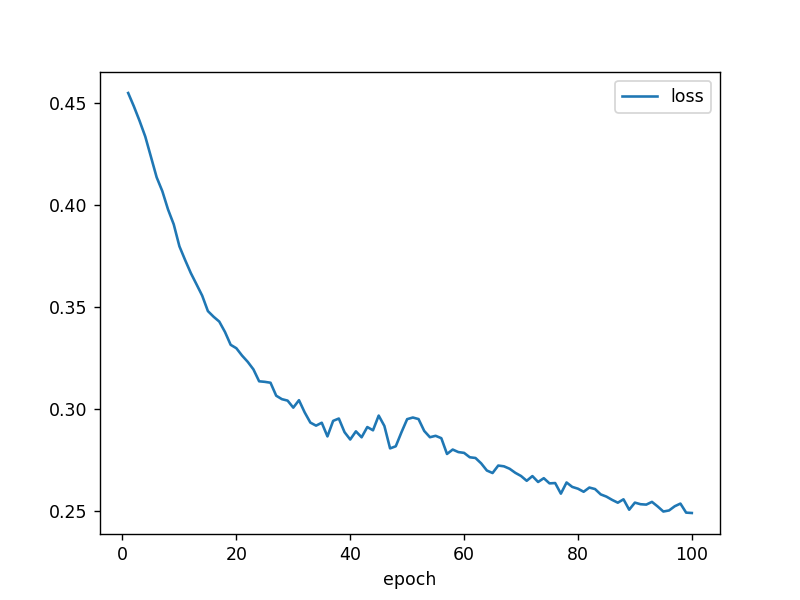

<Axes: xlabel='epoch'>

In [69]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='loss', x='epoch')

<IPython.core.display.Javascript object>


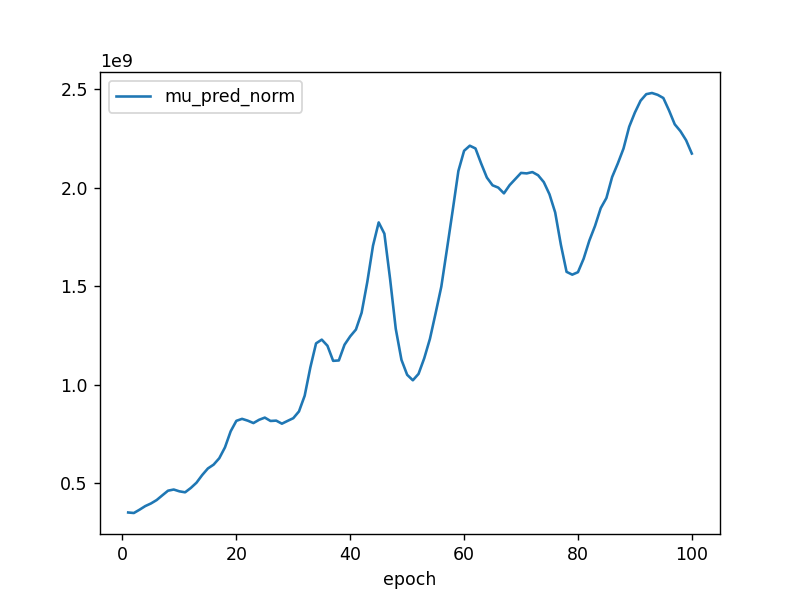

<Axes: xlabel='epoch'>

In [70]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='mu_pred_norm', x='epoch')

<IPython.core.display.Javascript object>


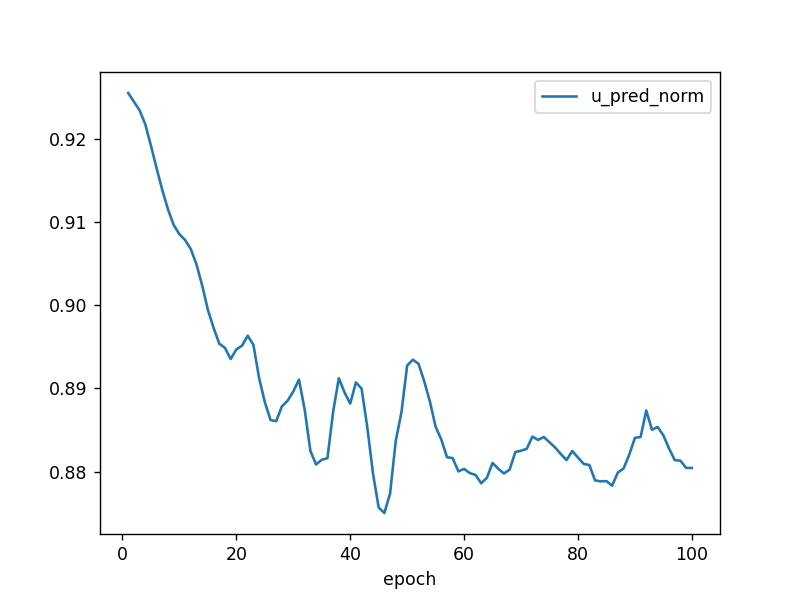

<Axes: xlabel='epoch'>

In [71]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='u_pred_norm', x='epoch')

<IPython.core.display.Javascript object>


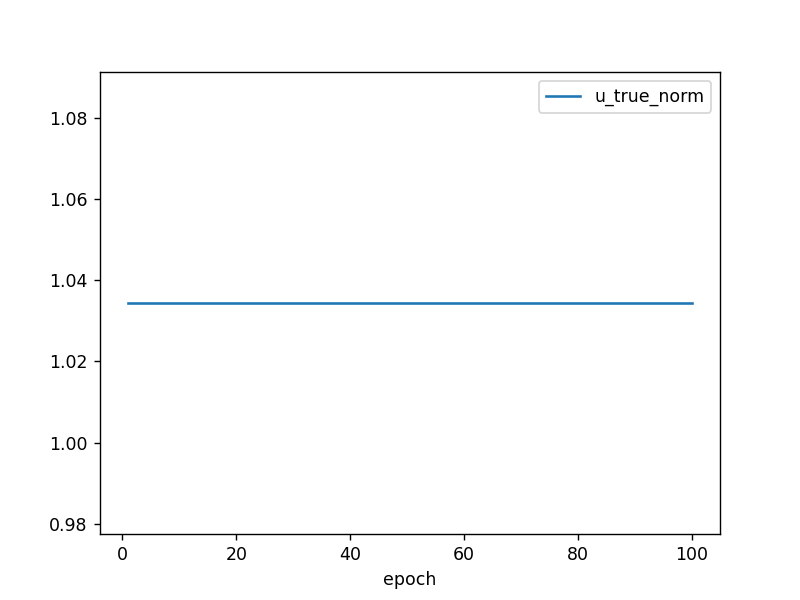

<Axes: xlabel='epoch'>

In [72]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='u_true_norm', x='epoch')

In [75]:
mu_pred_image, u_pred_image = trainer.test(dataset[0])
mu_pred_image

Tensor(shape=(1, 256, 256, 94), μ=1546.7841, σ=1570.6158, #nan=0, dtype=torch.float32, device=cuda:0)

In [76]:
u_pred_image

Tensor(shape=(3, 256, 256, 94), μ=0.0193, σ=0.2402, #nan=0, dtype=torch.float64, device=cpu)

<IPython.core.display.Javascript object>


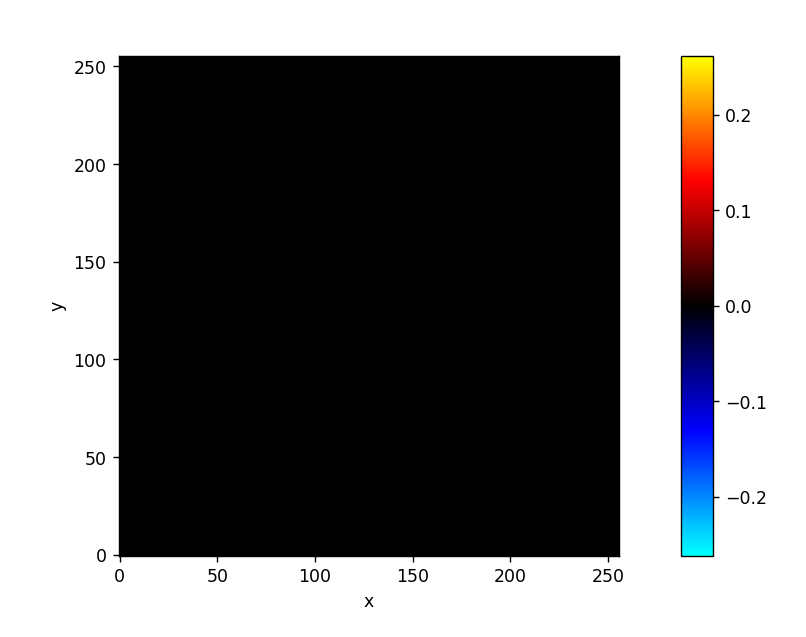

interactive(children=(SelectionSlider(description='c', options=((0, 0), (1, 1), (2, 2)), value=0), SelectionSl…

In [77]:
project.visual.view(as_xarray(u_true_image * mask, dims=['c', 'x', 'y', 'z'], name='u'))

In [78]:
anat_image, u_true_image, mask, mesh, resolution, example_name = dataset[0]
shape = tuple(anat_image.shape[1:])
shape, resolution

((256, 256, 94), (0.97, 0.97, 2.5))

<IPython.core.display.Javascript object>


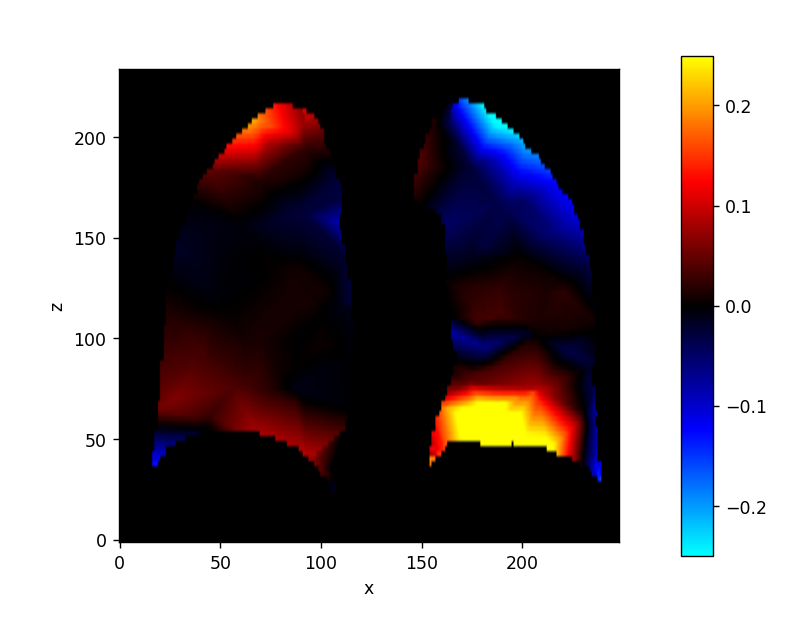

interactive(children=(SelectionSlider(description='c', options=(('x', 0), ('y', 1), ('z', 2)), value=0), Selec…

In [79]:
project.visual.view(as_xarray(
    u_pred_image * mask.cpu(),
    dims=['c', 'x', 'y', 'z'],
    coords={
        'c': ['x', 'y', 'z'],
        'x': np.arange(shape[0]) * resolution[0],
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
    },
    name='u'
), y='z')

In [80]:
anat_image = dataset[0][0]
mu_pred_image = trainer.model.forward(anat_image.unsqueeze(0))[0]
mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000

<IPython.core.display.Javascript object>


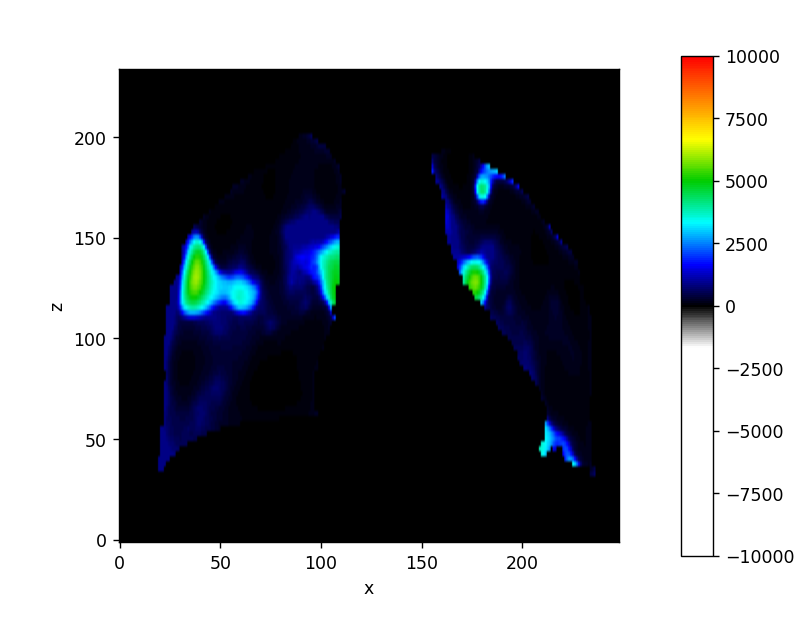

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

In [106]:
project.visual.view(as_xarray(
    mu_pred_image * mask,
    dims=['c', 'x', 'y', 'z'],
    coords={
        'c': [0],
        'x': np.arange(shape[0]) * resolution[0],
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
    },
    name='mu'
), y='z', vmax=1e4)

In [90]:
mu_pred_image = mu_pred_image.detach()
mu_pred_image.requires_grad = True
mu_pred_image

Tensor(shape=(1, 256, 256, 94), μ=1546.7841, σ=1570.6158, #nan=0, dtype=torch.float32, device=cuda:0)

In [91]:
pde = LinearElasticPDE(mesh)

mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image, resolution, pde.S, radius=20, sigma=mesh_radius/2)
mu_pred_dofs

Tensor(shape=(346,), μ=1236.6262, σ=986.6995, #nan=0, dtype=torch.float64, device=cuda:0)

In [92]:
L = mu_pred_dofs.sum()
L

Tensor(shape=(), μ=427872.6750, σ=nan, #nan=0, dtype=torch.float64, device=cuda:0)

In [93]:
L.backward()

In [100]:
mu_pred_image.shape

torch.Size([1, 256, 256, 94])

In [101]:
mu_interp_image = project.interpolate.dofs_to_image(mu_pred_dofs, pde.S, mu_pred_image.shape[-3:], resolution)
mu_interp_image

array([[[ 5464.56152096,  5566.03451124,  6382.73942317, ...,
         -2240.14899871, -2294.48047797, -3939.35192216],
        [ 5393.28193553,  5494.75492581,  5596.2279161 , ...,
         -2231.20907349, -2285.54055275, -3923.07133759],
        [ 5322.00235011,  5423.47534039,  5524.94833067, ...,
         -3158.31614702, -2276.60062753, -3973.98056137],
        ...,
        [ 2462.01279268,  2448.17997281,  2434.34715295, ...,
           793.47204043,   796.66595876,   799.85987709],
        [ 2483.32799502,  2469.49517516,  2455.6623553 , ...,
          6731.10676904,  6227.41753176,   803.76565827],
        [ 2504.64319736,  2490.8103775 ,  2476.97755764, ...,
           801.28360279,   804.47752112,   807.67143945]],

       [[ 6093.13468907,  6222.21236873,  6351.29004839, ...,
         -2234.39364555, -2288.72512482, -3928.62784362],
        [ 6020.33855971,  6149.41623937,  6278.49391903, ...,
         -2225.45372033, -2705.29954312, -3912.34725905],
        [ 5947.54243035, 

In [102]:
mu_interp_image.shape

(256, 256, 94)

<IPython.core.display.Javascript object>


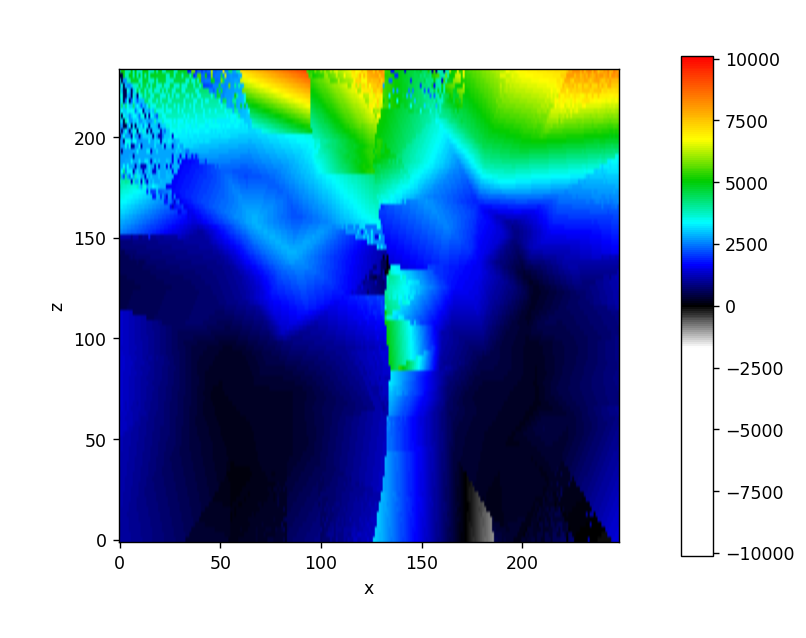

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [104]:
project.visual.view(as_xarray(
    mu_interp_image,
    dims=['x', 'y', 'z'],
    coords={
        'x': np.arange(shape[0]) * resolution[0],
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
    },
    name='mu'
), y='z')

<IPython.core.display.Javascript object>


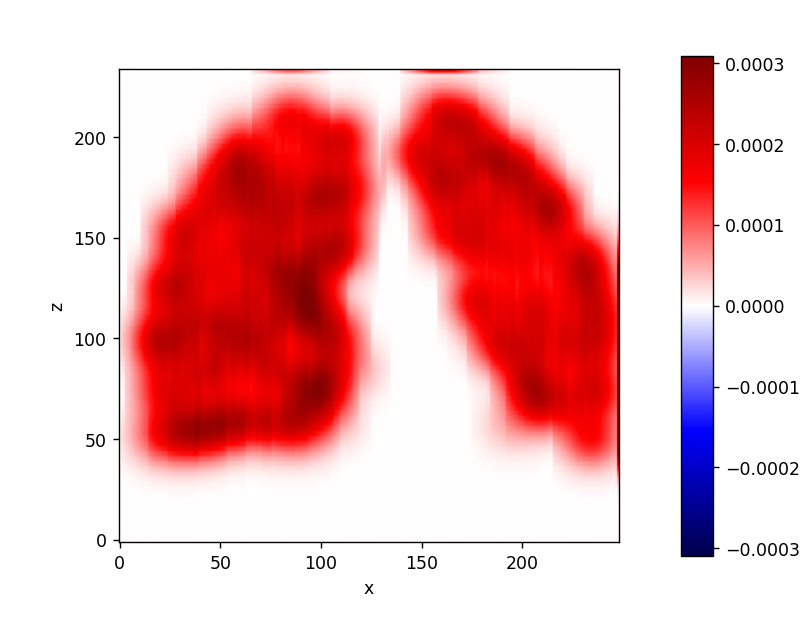

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

In [98]:
project.visual.view(as_xarray(
    mu_pred_image.grad,
    dims=['c', 'x', 'y', 'z'],
    coords={
        'c': [0],
        'x': np.arange(shape[0]) * resolution[0],
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
    }
), y='z', cmap='seismic')